<a href="https://colab.research.google.com/github/luismiguelaristi/jupyterTest/blob/master/PROMESA_EvidenciasRegistroPrototipo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evidencias para registro de prototipo

Verificar existencia de datos:
- durante pruebas
- desde el despliegue de las estaciones en sitios definitivos

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

## Lectura de datos Estaciones

Datos exportados desde 2022-10-20 10:00:00, con periodicidad de 5 minutos. Un año de datos.

No se exporta con periodicidad menor ya que la plataforma kern-iop solo permite periodos de 1 minuto, y los sensores tienen un muestreo de 2 minutos mínimo.

- Se obtiene un diccionario con los datos de cada estación como dataframe.
- Se define la columna "Fecha" como índice
- Se convierte a datetime para hacer mediciones de tiempo

In [ ]:
dic_df = {"museo-siata": pd.read_csv('/content/drive/MyDrive/PROMESA/MuseoSiata_1A_5min-data-2023-10-20 10_09_26.csv'),
          "upb1": pd.read_csv('/content/drive/MyDrive/PROMESA/UPB1_1A_5min-data-2023-10-20 10_09_26.csv'),
          "upb2": pd.read_csv('/content/drive/MyDrive/PROMESA/UPB2_1A_5min-data-2023-10-20 10_09_26.csv'),
          "ferias": pd.read_csv('/content/drive/MyDrive/PROMESA/Ferias_1A_5min-data-2023-10-20 10_09_26.csv'),
          "puente-aranda": pd.read_csv('/content/drive/MyDrive/PROMESA/PuenteAranda_1A_5min-data-2023-10-20 10_09_26.csv'),
          "colina": pd.read_csv('/content/drive/MyDrive/PROMESA/Colina_1A_5min-data-2023-10-20 10_09_26.csv')}

for eca,df in dic_df.items():
  dic_df[eca] = dic_df[eca].set_index("Fecha")
  dic_df[eca].index = pd.to_datetime(dic_df[eca].index)


## Filtro hasta fecha de instalación

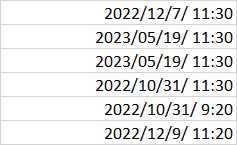

## Limpieza de datos

- Se separan los datos nulos de los no nulos. Se retienen los nulos para hacer análisis de periodos de silencio.
- Sobre estos, se mide el tiempo entre entradas, si el tiempo es superior a 10 minutos, tome la hora de adquisición como fallida y guarde la hora de inicio del fallo (clave) y duración (valor).
  - Si está leyendo fallos de un mismo día, súmelos

In [ ]:
dic_df_filt = {}
dic_info = {}
fechas = {"museo-siata": pd.to_datetime("2022-12-07"),
          "upb1": pd.to_datetime("2023-05-19"),
          "upb2": pd.to_datetime("2023-05-19"),
          "ferias": pd.to_datetime("2022-10-31"),
          "puente-aranda": pd.to_datetime("2022-10-31"),
          "colina": pd.to_datetime("2022-12-09")}
for eca,fecha in fechas.items():
  dic_df_filt[eca] = dic_df[eca].loc[dic_df[eca].index.to_series().between(fecha,"now")]
  noNulos = dic_df_filt[eca][pd.notnull(dic_df_filt[eca]["PM10"])]
  t_ini = noNulos.index[0]
  deltas_t = {}
  index_t = []
  ultimo_dato = dic_df_filt[eca].iloc[-1] # como Series
  filas = dic_df_filt[eca].shape[0]
  ultimo_dato_df = dic_df_filt[eca].iloc[filas-2:filas-1,:] #como Dataframe
  # print(ultimo_dato)
  if pd.isna(ultimo_dato["PM10"]): #si el último dato del dataset es nulo
    noNulos = pd.concat([noNulos,ultimo_dato_df])
    # print(noNulos)
  for t in dic_df_filt[eca].index: # crear las keys para todos los días, aun si no hay apagón
    # key = t.strftime("%Y-%m-%d")
    key = t.date()
    if key not in index_t:
      index_t.append(key)
    if t in noNulos.index: # esto es para los días con apagón
      delta_t = t-t_ini
      if delta_t.components.minutes > 10:
        # cree la entrada si no existe
        if deltas_t.get(key) is None:
          deltas_t[key] = delta_t
        else:
          deltas_t[key] += delta_t
      else:
        pass
      # actualice valores anteriores
      t_ini = t
  dic_info[eca] = deltas_t
# dic_df["colina"]
# dic_info
index_t
# dic_df_filt["colina"]


[datetime.date(2022, 12, 9),
 datetime.date(2022, 12, 10),
 datetime.date(2022, 12, 11),
 datetime.date(2022, 12, 12),
 datetime.date(2022, 12, 13),
 datetime.date(2022, 12, 14),
 datetime.date(2022, 12, 15),
 datetime.date(2022, 12, 16),
 datetime.date(2022, 12, 17),
 datetime.date(2022, 12, 18),
 datetime.date(2022, 12, 19),
 datetime.date(2022, 12, 20),
 datetime.date(2022, 12, 21),
 datetime.date(2022, 12, 22),
 datetime.date(2022, 12, 23),
 datetime.date(2022, 12, 24),
 datetime.date(2022, 12, 25),
 datetime.date(2022, 12, 26),
 datetime.date(2022, 12, 27),
 datetime.date(2022, 12, 28),
 datetime.date(2022, 12, 29),
 datetime.date(2022, 12, 30),
 datetime.date(2022, 12, 31),
 datetime.date(2023, 1, 1),
 datetime.date(2023, 1, 2),
 datetime.date(2023, 1, 3),
 datetime.date(2023, 1, 4),
 datetime.date(2023, 1, 5),
 datetime.date(2023, 1, 6),
 datetime.date(2023, 1, 7),
 datetime.date(2023, 1, 8),
 datetime.date(2023, 1, 9),
 datetime.date(2023, 1, 10),
 datetime.date(2023, 1, 11),
 

In [ ]:
downtime_df = pd.DataFrame(dic_info,index=index_t)
downtime_df

,museo-siata,upb1,upb2,ferias,puente-aranda,colina
2022-12-09,0 days 08:50:00,NaT,NaT,19 days 00:45:00,0 days 00:15:00,0 days 00:45:00
2022-12-10,0 days 10:20:00,NaT,NaT,0 days 00:15:00,NaT,NaT
2022-12-11,0 days 07:45:00,NaT,NaT,NaT,NaT,NaT
2022-12-12,0 days 03:20:00,NaT,NaT,0 days 00:15:00,0 days 00:15:00,NaT
2022-12-13,0 days 07:45:00,NaT,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...
2023-10-16,NaT,NaT,NaT,NaT,NaT,NaT
2023-10-17,NaT,NaT,NaT,0 days 00:30:00,0 days 00:15:00,NaT
2023-10-18,NaT,NaT,NaT,0 days 00:15:00,0 days 00:15:00,NaT
2023-10-19,NaT,NaT,NaT,0 days 00:45:00,NaT,NaT


## Estadísticos

en esta tabla se reportan cantidades de tiempo de las estaciones fuera de linea, contado en días.



In [ ]:
stats = downtime_df.describe()
stats.loc["sum"] = downtime_df.sum()
for eca,fecha in fechas.items():
  stats.at["fecha instalación",eca] = fecha
  stats.at["días desde instalación",eca] = (ultimo_dato.name-fecha).days
stats = stats.drop(["count","min","std","25%","50%","75%"])
stats

,museo-siata,upb1,upb2,ferias,puente-aranda,colina
mean,0 days 17:01:11.052631578,4 days 02:32:46.666666666,1 days 00:15:16.438356164,0 days 02:55:26.033057851,0 days 05:59:42.743362831,0 days 10:51:34.736842105
max,41 days 21:10:00,36 days 19:45:00,49 days 04:55:00,19 days 00:45:00,13 days 23:55:00,6 days 21:15:00
sum,80 days 20:15:00,36 days 22:55:00,73 days 18:35:00,29 days 11:35:00,56 days 10:55:00,8 days 14:20:00
fecha instalación,2022-12-07 00:00:00,2023-05-19 00:00:00,2023-05-19 00:00:00,2022-10-31 00:00:00,2022-10-31 00:00:00,2022-12-09 00:00:00
días desde instalación,317,154,154,354,354,315


## Exportar resultados

Esta operación toma mucho tiempo, descomentar para realizar.

In [ ]:
# with pd.ExcelWriter("/content/drive/MyDrive/PROMESA/ResumenEstacionesPromesa.xlsx",engine='openpyxl') as miArchivoExcel:
#     for eca,df in dic_df_filt.items():
#         df.to_excel(miArchivoExcel,sheet_name=eca)
#     # opcional: podemos agregar también el DataFrame de cálculos estadísticos
#     stats.to_excel(miArchivoExcel,sheet_name='estadisticos')

## Graficar

In [ ]:
downtime_df.values

array([[  31800000000000,            'NaT',            'NaT',
        1644300000000000,     900000000000,    2700000000000],
       [  37200000000000,            'NaT',            'NaT',
            900000000000,            'NaT',            'NaT'],
       [  27900000000000,            'NaT',            'NaT',
                   'NaT',            'NaT',            'NaT'],
       ...,
       [           'NaT',            'NaT',            'NaT',
            900000000000,     900000000000,            'NaT'],
       [           'NaT',            'NaT',            'NaT',
           2700000000000,            'NaT',            'NaT'],
       [           'NaT', 3181500000000000, 4251300000000000,
            900000000000,     900000000000,            'NaT']],
      dtype='timedelta64[ns]')

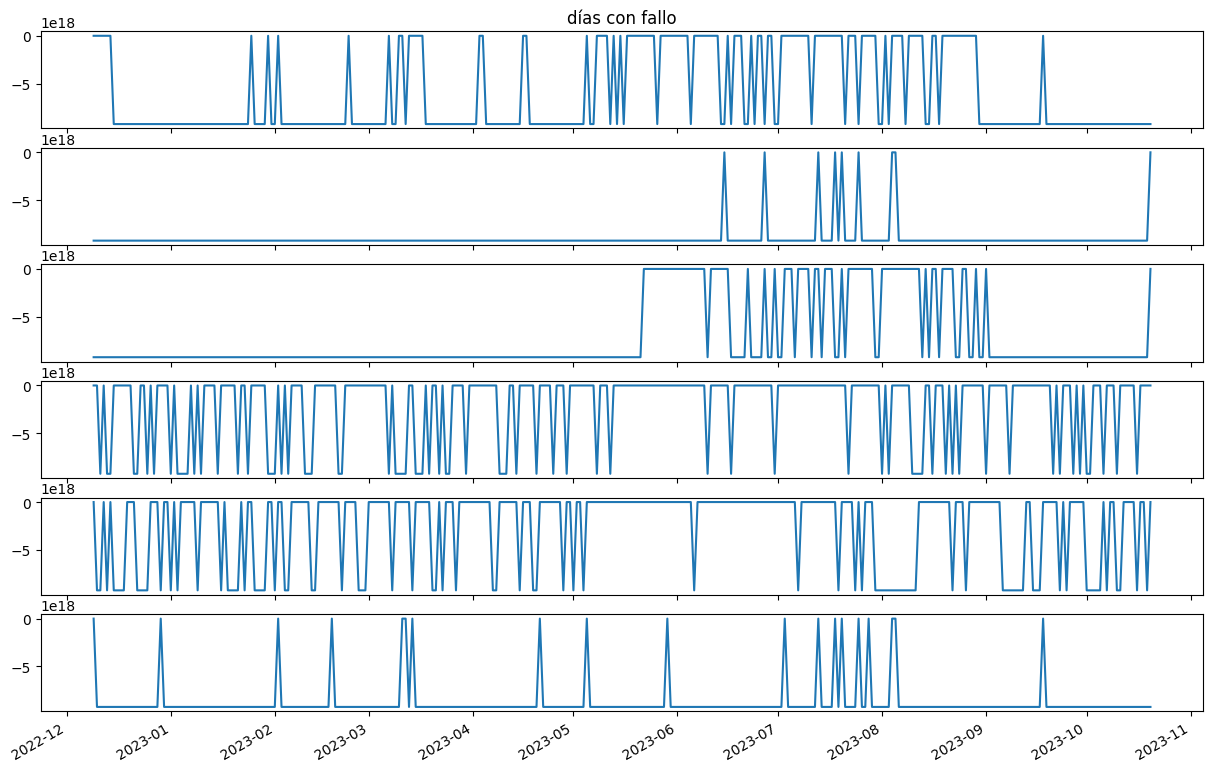

In [ ]:
fig,axes = plt.subplots(6,1)
plt.rcParams['figure.figsize'] = [15, 10]
axes[0].set_title("días con fallo")
for ax,eca in zip(axes,fechas.keys()):
  ax.plot(downtime_df.index,downtime_df[eca])
  plt.gcf().autofmt_xdate()
